In [20]:
import json
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import spacy
from typing import Dict, List, Union
import json
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import spacy
from typing import Dict, List, Union

In [21]:
# Load Training data
with open("spider_data/spider_data/train_spider.json", "r") as f:
    train_spider_data = json.load(f)
with open("spider_data/spider_data/train_others.json", "r") as f:
    train_others_data = json.load(f)
train_data = train_spider_data + train_others_data


# Load Validation Data
with open("spider_data/spider_data/dev.json", "r") as f:
    dev_data = json.load(f)


# Load Test Data
with open("spider_data/spider_data/test.json", "r") as f:
    test_data = json.load(f)

In [22]:
# Create Dataframes
train_data_df = pd.DataFrame(train_data)
dev_data_df = pd.DataFrame(dev_data)
test_data_df = pd.DataFrame(test_data)

In [23]:
# Inspect Dataframes
print(train_data_df.columns)
print(dev_data_df.columns)
print(test_data_df.columns)

Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')
Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')
Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')


In [24]:
# Print first row of train_data Dataframe
train_data_df.iloc[1]

db_id                                              department_management
query                  SELECT name ,  born_state ,  age FROM head ORD...
query_toks             [SELECT, name, ,, born_state, ,, age, FROM, he...
query_toks_no_value    [select, name, ,, born_state, ,, age, from, he...
question               List the name, born state and age of the heads...
question_toks          [List, the, name, ,, born, state, and, age, of...
sql                    {'from': {'table_units': [['table_unit', 1]], ...
Name: 1, dtype: object

In [25]:
from typing import Counter


nlp = spacy.load("en_core_web_sm")

def extract_linguistic_features(question: str) -> Dict[str, Union[bool, int]]:
    """
    TODO:
    """
    
    doc = nlp(question)
    features = {
        "num_tokens": len(doc),  # Number of Tokens
        "num_nouns": sum(1 for token in doc if token.pos_ == "NOUN"),  # Number of Nouns
        "num_verbs": sum(1 for token in doc if token.pos_ == "VERB"),  # Number of Verbs
        "num_adjectives": sum(1 for token in doc if token.pos_ == "ADJ"),  # Number of Adjectives
        "is_wh_question": any(token.text.lower() in ["what", "where", "who", "how", "why"] for token in doc),  # True if wh-question (TODO: wie heißt das?)
        "dependency_tree_depth": max([token.head.i for token in doc] + [0]),  # Dependency Tree Depth

        # sentence structure complexity
        "average_sentence_length": sum(len(sentence) for sentence in doc.sents) / len(list(doc.sents)) if len(list(doc.sents)) > 0 else 0, # maybe a question has more than one sentence
        "num_subordinated_clauses": sum(1 for token in doc if token.dep_ in ["ccomp", "advcl", "mark"]),
        
        # NER
        "num_persons": sum(1 for ent in doc.ents if ent.label_ == "PERSON"),
        "num_orgs": sum(1 for ent in doc.ents if ent.label_ == "ORG"),
        "num_locations": sum(1 for ent in doc.ents if ent.label_ == "GPE"),
        "num_entities": len(doc.ents),
        
        
        "num_unique_dependencies": len(set(token.dep_ for token in doc)),
        
        # grammar
        "has_negation": any(token.text.lower() in ["not", "no"] for token in doc),
        
        # Word Frequencies
        "top_5_words": Counter(token.text.lower() for token in doc if token.pos_ in ["NOUN", "VERB"]).most_common(5)
    }

    return features

In [26]:
# Extract linguistic features
train_data_df["linguistic_features"] = train_data_df["question"].apply(extract_linguistic_features)

# feature names (for dynamic access to "linguistic features" columns)
features = list(extract_linguistic_features("").keys())

In [27]:
# Extend Dataframe with the extracted features
train_df = pd.concat([train_data_df, train_data_df["linguistic_features"].apply(pd.Series)], axis=1)

In [28]:
# Show first row of with linguistic features extended Dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(train_df.iloc[[0,1,2]])


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql,linguistic_features,num_tokens,num_nouns,num_verbs,num_adjectives,is_wh_question,dependency_tree_depth,average_sentence_length,num_subordinated_clauses,num_persons,num_orgs,num_locations,num_entities,num_unique_dependencies,has_negation,top_5_words
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ...","{'num_tokens': 11, 'num_nouns': 2, 'num_verbs'...",11,2,0,2,True,8,11.0,0,0,0,0,1,9,False,"[(heads, 1), (departments, 1)]"
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ...","{'num_tokens': 17, 'num_nouns': 6, 'num_verbs'...",17,6,3,0,False,14,17.0,0,0,0,0,0,12,False,"[(age, 2), (list, 1), (name, 1), (born, 1), (s..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ...","{'num_tokens': 12, 'num_nouns': 5, 'num_verbs'...",12,5,1,0,False,10,12.0,0,0,0,0,1,9,False,"[(list, 1), (creation, 1), (year, 1), (name, 1..."


## Get the Diffuculty Level using their Evaluator

https://github.com/taoyds/spider/blob/master/evaluation.py#L362

In [29]:
from evaluation import Evaluator

evaluator = Evaluator()

train_df["hardness"] = train_df["sql"].apply(lambda sql: evaluator.eval_hardness(sql))
small_train_data_df = train_df[["query", "question", "hardness", *features]]

In [30]:
small_train_data_df.head(5)

,query,question,hardness,num_tokens,num_nouns,num_verbs,num_adjectives,is_wh_question,dependency_tree_depth,average_sentence_length,num_subordinated_clauses,num_persons,num_orgs,num_locations,num_entities,num_unique_dependencies,has_negation,top_5_words
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,easy,11,2,0,2,True,8,11.0,0,0,0,0,1,9,False,"[(heads, 1), (departments, 1)]"
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...",medium,17,6,3,0,False,14,17.0,0,0,0,0,0,12,False,"[(age, 2), (list, 1), (name, 1), (born, 1), (s..."
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...",medium,12,5,1,0,False,10,12.0,0,0,0,0,1,9,False,"[(list, 1), (creation, 1), (year, 1), (name, 1..."
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,medium,11,2,0,2,True,9,11.0,0,0,0,0,0,10,False,"[(budget, 1), (departments, 1)]"
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,easy,18,4,0,1,True,14,18.0,0,0,0,0,1,13,False,"[(number, 1), (employees, 1), (departments, 1)..."


In [31]:
groups = small_train_data_df.groupby(["hardness"])

In [32]:
# Nice colors for plotting :)
colors = {
    "easy": "#FF6F91",    # Pink
    "medium": "#FF9671",   # Orange
    "hard": "#6A9EFF",     # Blue
    "extra": "#A277FF"     # Purple
}

hardness_order = ['easy', 'medium', 'hard', 'extra']

## Boxplot number of Tokens per Diffuculty Level

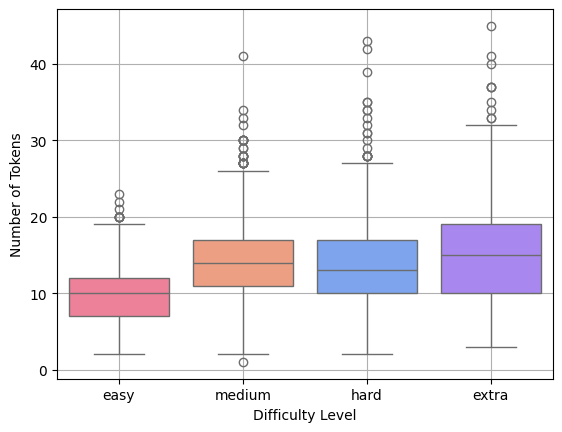

In [33]:
sns.boxplot(x="hardness", y="num_tokens", data=small_train_data_df, palette=colors, hue="hardness")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Tokens")
plt.grid(True)
plt.show()

The more tokens in the question, the higher the difficulty level. <br>
Conclusion: No significant differences.

## Compare the ratio num_query_toks / num_tokens per Hardness Level.
Determine whether the length of SQL queries, relative to the Length of questions, correlates with the difficulty of the tasks. (num_query_toks/num_tokens = e.g. are the queries shorter than the question? )

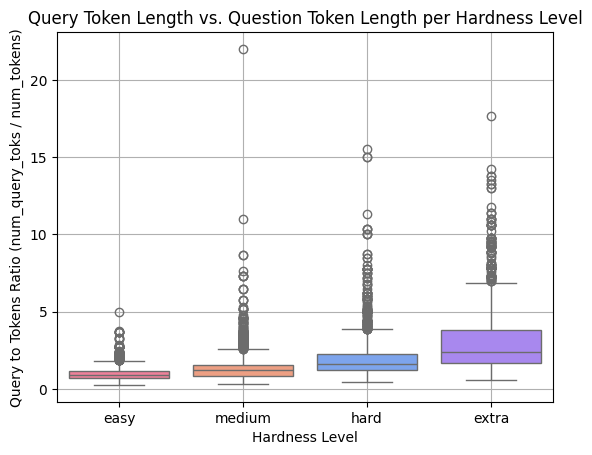

In [34]:
# Calculate num_query_toks
train_df['num_query_toks'] = train_df['query_toks'].apply(len)

# Calculate the ratio: num_query_toks / num_tokens
train_df['query_to_tokens_ratio'] = train_df['num_query_toks'] / train_df['num_tokens']

sns.boxplot(x='hardness', y='query_to_tokens_ratio', data=train_df, palette=colors, hue='hardness')
plt.title('Query Token Length vs. Question Token Length per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Query to Tokens Ratio (num_query_toks / num_tokens)')
plt.grid(True)
plt.show()

Queries sind länger bei gleich langer Frage.

## Number of POS per hardness level (proportional)

In [35]:
def plot_pos_per_hardness_level(results: List[float], labels: List[str]) -> None:
    """
    TODO:
    """
    _, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (res, title) in enumerate(zip(results, labels)):
        res = res.loc[["easy", "medium", "hard", "extra"]]
        
        axes[i].plot(res.index, res.values, marker='o', linestyle='-', color='pink', lw=6)
        axes[i].set_title(title)
        axes[i].set_xlabel("Hardness")
        axes[i].set_ylabel("Adjectives per Token")
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

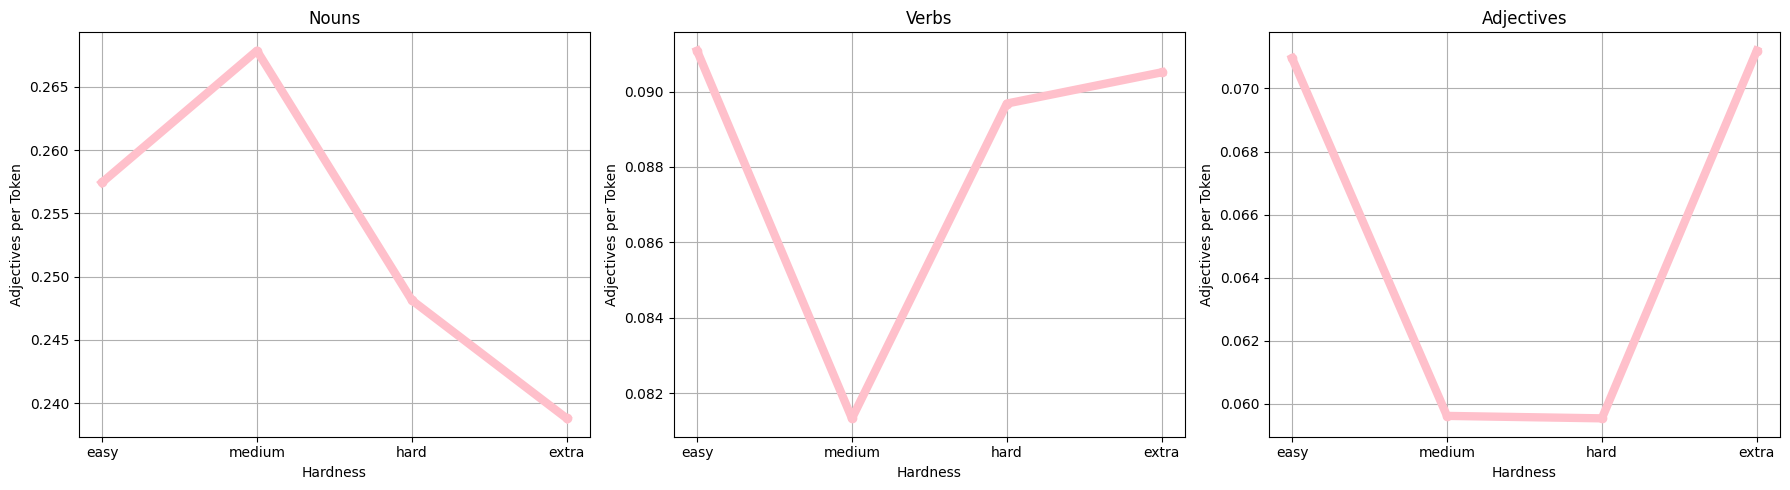

In [36]:
# Number of pos per question (proportional)
# Quotient für jede frage geteilt durch durschnitt von allen
results = [
    groups["num_nouns"].mean() / groups["num_tokens"].mean(),
    groups["num_verbs"].mean() / groups["num_tokens"].mean(),
    groups["num_adjectives"].mean() / groups["num_tokens"].mean()
]

plot_pos_per_hardness_level(results=results, labels=["Nouns", "Verbs", "Adjectives"])

## Plot number of query tokens against number of question tokens

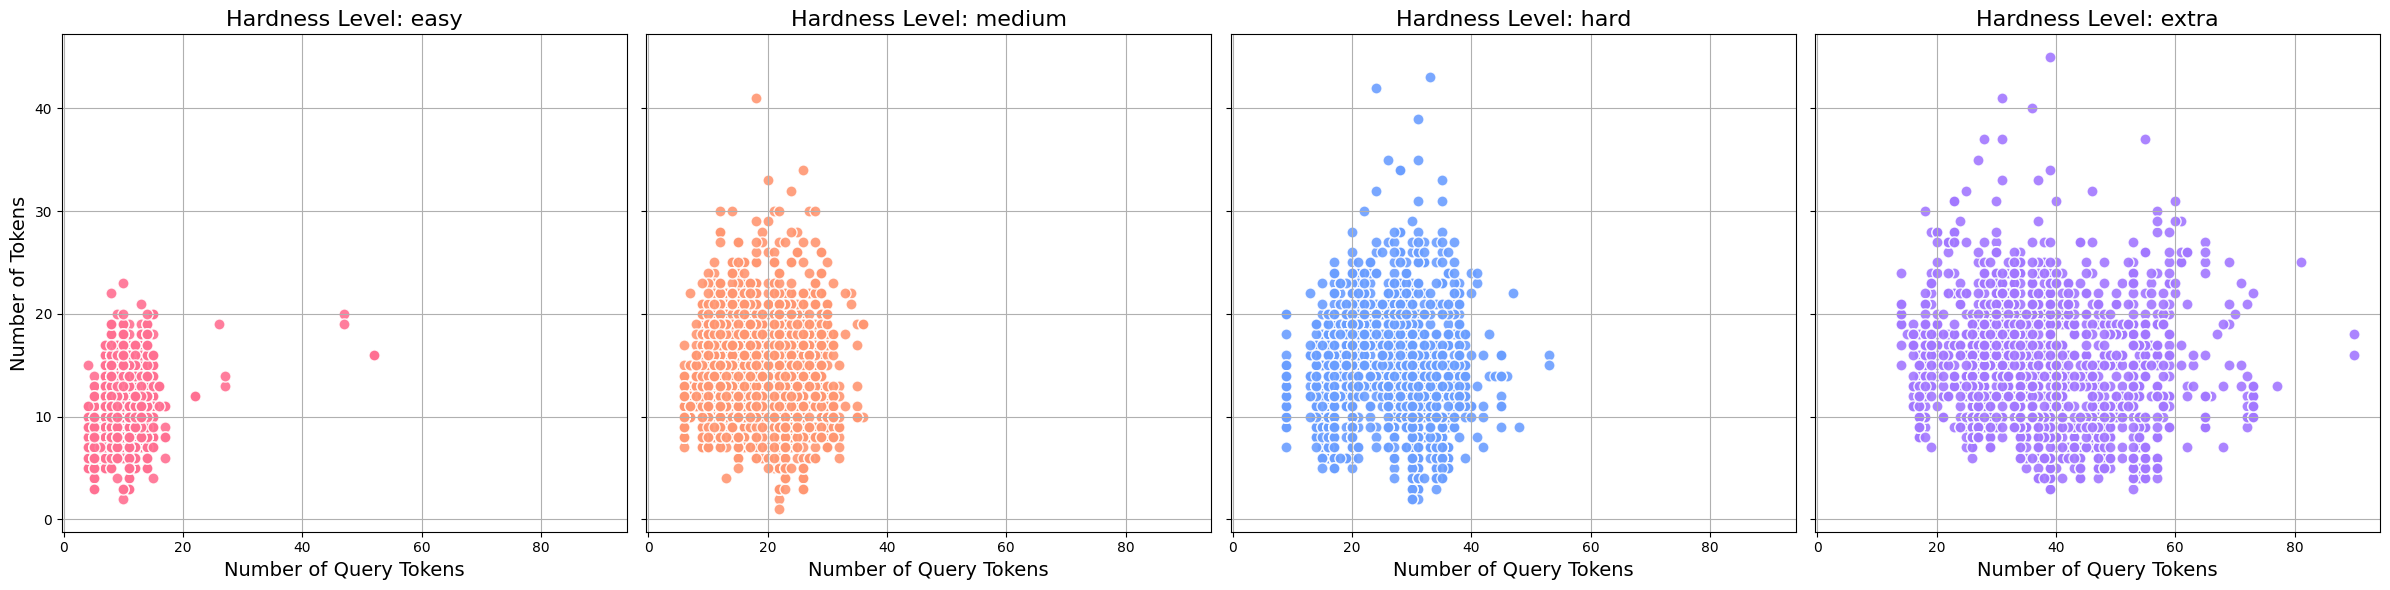

In [37]:
def plot_query_toks_to_num_toks_in_hardness_splits(train_df):
    # Number of tokens in the 'query_toks' column
    train_df['num_query_toks'] = train_df['query_toks'].apply(len)

    hardness_levels = list(colors.keys())

    # Create subplots
    _, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True, sharex=True)

    for i, hardness in enumerate(hardness_levels):
        subset = train_df[train_df['hardness'] == hardness]
        
        # Plot scatterplots
        axes[i].scatter(
            subset['num_query_toks'], subset['num_tokens'], 
            color=colors[hardness], s=64, alpha=0.9, edgecolor="white"
        )
        axes[i].set_title(f'Hardness Level: {hardness}', fontsize=16)
        axes[i].set_xlabel('Number of Query Tokens', fontsize=14)
        
        if i == 0:
            axes[i].set_ylabel('Number of Tokens', fontsize=14)
        
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

plot_query_toks_to_num_toks_in_hardness_splits(train_df)

The scatter plots show where increasing query hardness ('easy' to 'extra') corresponds with a rise in both the number of query tokens and tokens. <br>'Easy' queries are clustered around low values for both metrics, while 'medium' and 'hard' queries expand this range, in particular along the number of query tokens axis. <br> The 'extra' hardness level shows the most scattered pattern, with high variability across both axes, indicating that complex queries tend to be longer and more diverse in structure.

In [38]:
groups["is_wh_question"].mean()

hardness
easy      0.593041
extra     0.570940
hard      0.569199
medium    0.543515
Name: is_wh_question, dtype: float64

## Calculcate the Average Dependency Tree Depth per Hardness Level

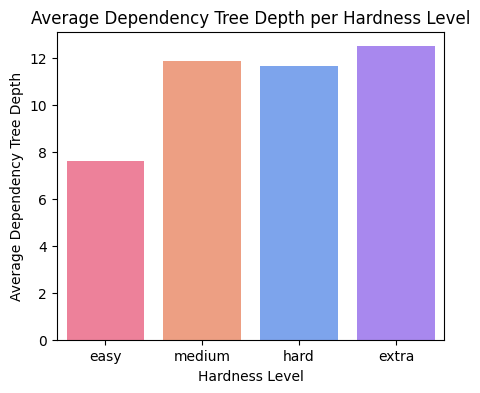

In [39]:
avg_depth_per_hardness = train_df.groupby('hardness')['dependency_tree_depth'].mean().reset_index()

plt.figure(figsize=(5, 4))

sns.barplot(x='hardness', y='dependency_tree_depth', data=avg_depth_per_hardness, palette=colors, hue='hardness', order=hardness_order)
plt.title('Average Dependency Tree Depth per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Average Dependency Tree Depth')
plt.show()

## Plot Histogram for num_tokens by Hardness Level

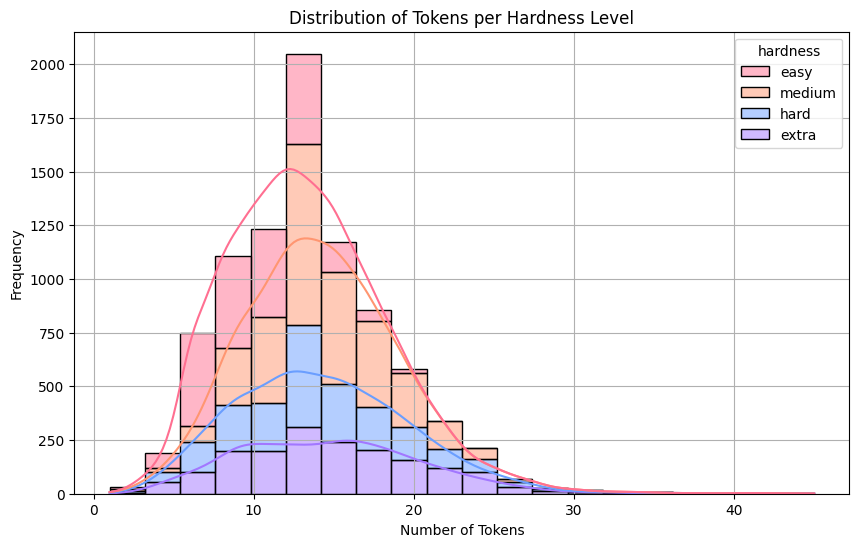

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='num_tokens', hue='hardness', kde=True, multiple="stack", bins=20, palette=colors)
plt.title('Distribution of Tokens per Hardness Level')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Average Type-Token Ratio (TTR) per Hardness Level

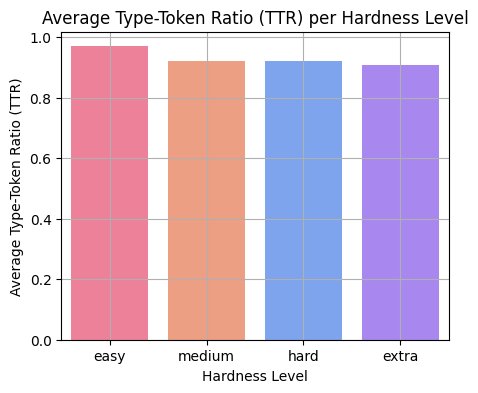

In [41]:
# Create a new column for unique words in the 'question_toks' column
train_df['unique_words'] = train_df['question_toks'].apply(lambda x: len(set(x)))

# Calculate Type-Token Ratio (TTR) for each question: unique_words / num_tokens
train_df['TTR'] = train_df['unique_words'] / train_df['num_tokens']

# Calculate the average TTR per hardness level
avg_TTR_per_hardness = train_df.groupby('hardness')['TTR'].mean().reset_index()

avg_TTR_per_hardness['hardness'] = pd.Categorical(avg_TTR_per_hardness['hardness'], categories=hardness_order, ordered=True)

plt.figure(figsize=(5, 4))
sns.barplot(x='hardness', y='TTR', data=avg_TTR_per_hardness, palette=colors, hue='hardness')
plt.title('Average Type-Token Ratio (TTR) per Hardness Level')
plt.xlabel('Hardness Level')
plt.ylabel('Average Type-Token Ratio (TTR)')
plt.grid(True)
plt.show()

Conclusion: <br> Lexical diversity (the ratio of unique words to total words) in the questions doesn't differ significantly based on their difficulty. <br>
"Easy" questions show a slightly higher TTR compared to the other difficulty levels. This means that, on average, easy questions use a very slightly higher variety of words relative to their length than medium, hard, or extra-hard questions.

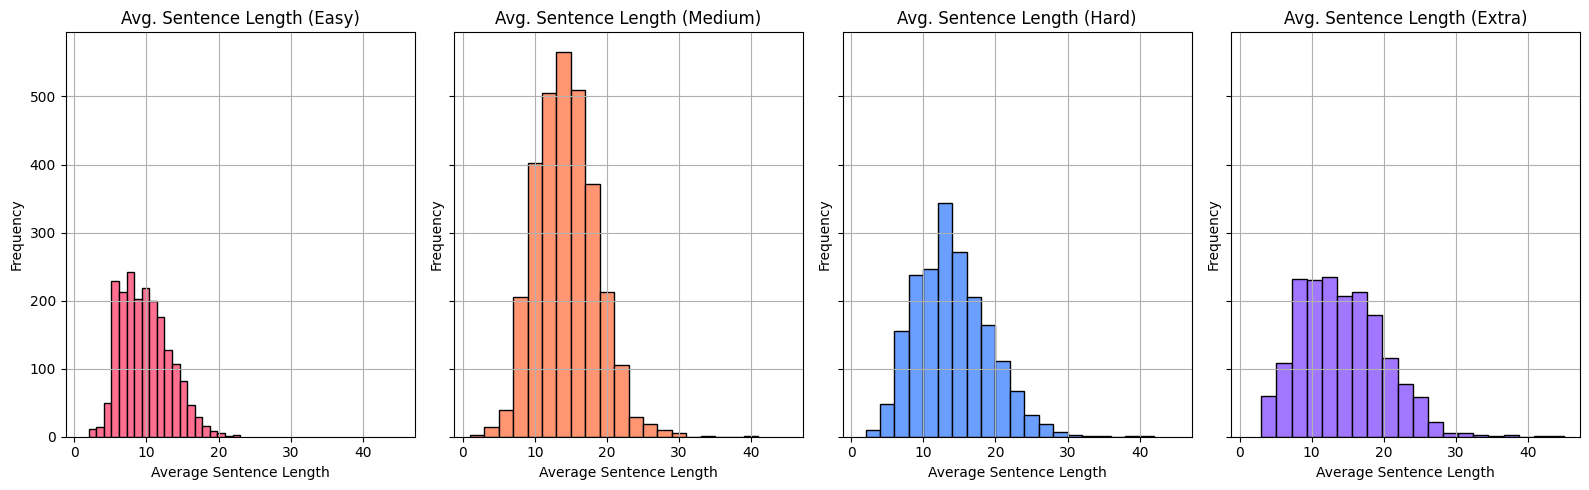

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True, sharex=True)

for i, difficulty in enumerate(hardness_order):
    ax = axes[i]
    subset = train_df[train_df['hardness'] == difficulty]
    ax.hist(subset['average_sentence_length'], bins=20, color=colors[difficulty], edgecolor='black')
    
    ax.set_title(f'Avg. Sentence Length ({difficulty.capitalize()})')
    ax.set_xlabel('Average Sentence Length')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

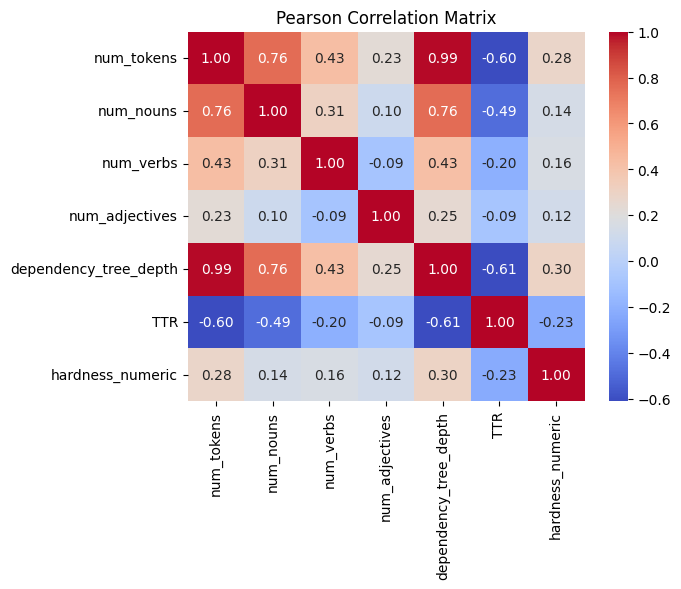

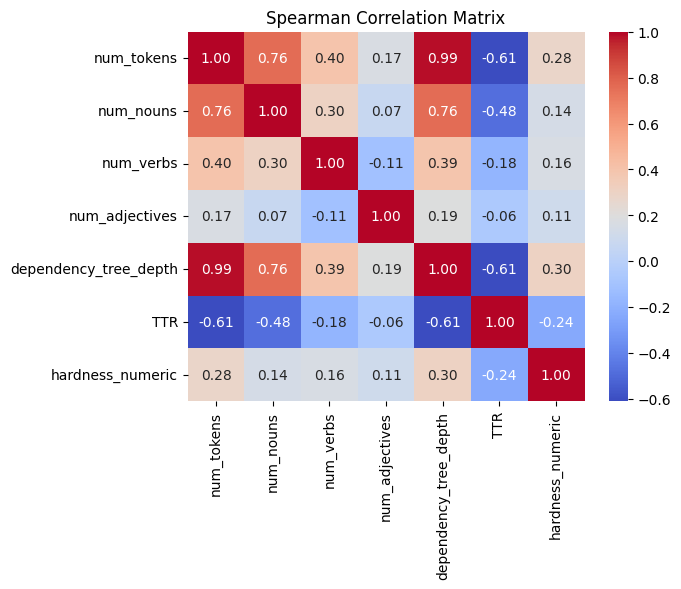

In [43]:
hardness_mapping = {'easy': 0, 'medium': 1, 'hard': 2, 'extra': 3}
train_df['hardness_numeric'] = train_df['hardness'].map(hardness_mapping)

# List of numeric columns for correlation analysis
numeric_columns = ['num_tokens', 'num_nouns', 'num_verbs', 'num_adjectives', 'dependency_tree_depth', 'TTR']

# Pearson Correlation (linear)
pearson_corr = train_df[numeric_columns + ['hardness_numeric']].corr()

# Plot Pearson Correlation Heatmap
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

# Spearman Correlation (monotonic)
spearman_corr, p_value = spearmanr(train_df[numeric_columns + ['hardness_numeric']])

# Convert the result to a DataFrame for better readability
spearman_corr_df = pd.DataFrame(spearman_corr, columns=numeric_columns + ['hardness_numeric'], index=numeric_columns + ['hardness_numeric'])

# Plot Spearman Correlation Heatmap
sns.heatmap(spearman_corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()


A -0.61 correlation between dependency_tree_depth and TTR indicates that more complex sentence structures tend to be associated with lower lexical diversity. <br> This suggests that as the syntactic complexity of queries increases, the vocabulary becomes more repetitive or less diverse. <br> <br>

A 0.60 correlation between num_tokens and TTR, means that as queries get longer, they tend to have more repetition in terms of vocabulary, which lowers the TTR.

Alle als einfach klassifizierten und dann TTR und wie sich das voneinander unterscheidet?